In [1]:
pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git


  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to /tmp/pip-req-build-mufaybyb
  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git /tmp/pip-req-build-mufaybyb
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit ca2797e9270195313423324c9d0f205f6cbb3d28
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 10.6 MB/s eta 0:00:00
  Created wheel for text-flappy-bird-gym: filename=text_flappy_bird_gym-0.1.1-py3-none-any.whl size=7771 sha256=a1046e06215581ea8ee4f4afe6a004fdddec907ea43ab3f92b42fd0332d5f99a
  Stored in directory: /tmp/pip-ephem-wheel-cache-enag0phv/wheels/a1/07/d2/74e9570f22696f6a81089c4e5dbe11248ff1e4b3236dafe59d
Successfully built text-flappy-bird-gym
  Attempting uninstall: gymnasium
    Found existing installation: gym

## Made by Wenzheng Liu individually

In [2]:
import os, sys
import gymnasium as gym
import time
import numpy as np
from collections import defaultdict

import text_flappy_bird_gym

env = gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4)

# initinalize Q table
Q = defaultdict(lambda: np.zeros(env.action_space.n))

def preprocess_state(state):
    if isinstance(state, dict):
        return tuple(state.values())
    elif isinstance(state, np.ndarray):
        return tuple(state.flatten())
    return tuple(state)

def epsilon_greedy_policy(state, epsilon=0.1):
    """ε-greedy strategy"""
    state = preprocess_state(state)
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    return np.argmax(Q[state])

def monte_carlo_control(num_episodes=5000, gamma=0.9, epsilon=0.1):
    """MC method"""
    returns = defaultdict(list)
    mc_rewards = []  #  save episode reward

    for episode in range(num_episodes):
        episode_data = []  # save (state, action, reward)
        state, _ = env.reset()
        state = preprocess_state(state)
        done = False
        total_reward = 0

        while not done:
            action = epsilon_greedy_policy(state, epsilon)
            next_state, reward, done, _, _ = env.step(action)
            next_state = preprocess_state(next_state)
            episode_data.append((state, action, reward))
            state = next_state
            total_reward += reward

        G = 0
        visited = set()
        for state, action, reward in reversed(episode_data):
            state = preprocess_state(state)
            G = gamma * G + reward
            if (state, action) not in visited:
                visited.add((state, action))
                returns[(state, action)].append(G)
                Q[state][action] = np.mean(returns[(state, action)])

        if (episode + 1) % 10 == 0:
            avg_reward = total_reward / 10
            mc_rewards.append(avg_reward)

        if (episode + 1) % 1000 == 0:
            print(f"Episode {episode + 1}/{num_episodes} completed, Average Reward: {avg_reward:.2f}")
    return mc_rewards


Episode 1000/10000 completed, Average Reward: 2.90
Episode 2000/10000 completed, Average Reward: 9.30
Episode 3000/10000 completed, Average Reward: 17.30
Episode 4000/10000 completed, Average Reward: 15.30
Episode 5000/10000 completed, Average Reward: 5.30
Episode 6000/10000 completed, Average Reward: 2.20
Episode 7000/10000 completed, Average Reward: 28.30
Episode 8000/10000 completed, Average Reward: 27.10
Episode 9000/10000 completed, Average Reward: 13.30
Episode 10000/10000 completed, Average Reward: 11.20


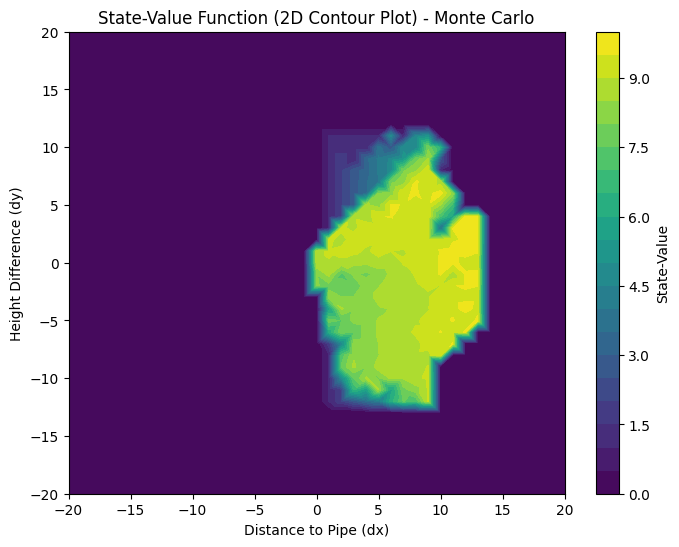

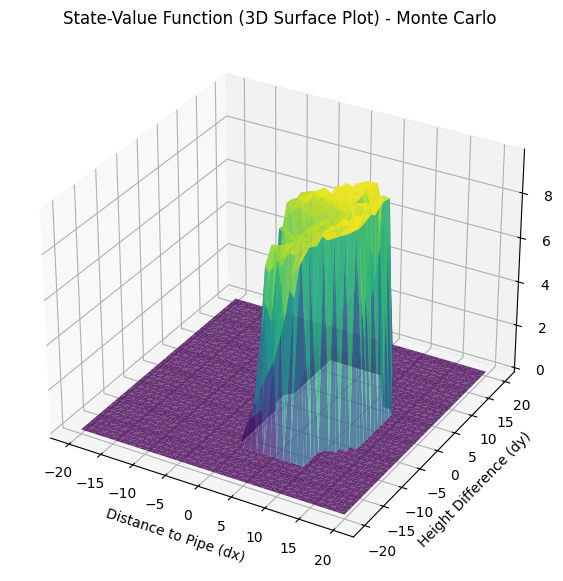

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Train process

mc_rewards = monte_carlo_control(num_episodes=10000, gamma=0.9, epsilon=0.1)



def plot_value_function(Q, state_space):
    """
    Plots a 2D contour plot of the state-value function (for use with Monte Carlo Q-tables).
    Q: trained Q-table (dictionary)
    state_space: list of all states [(x, y), ...]
    """
    x_vals = [state[0] for state in state_space]
    y_vals = [state[1] for state in state_space]
    z_vals = [max(Q.get(state, [0, 0])) for state in state_space]

    plt.figure(figsize=(8, 6))
    plt.tricontourf(x_vals, y_vals, z_vals, levels=20, cmap="viridis")
    plt.colorbar(label="State-Value")
    plt.title('State-Value Function (2D Contour Plot) - Monte Carlo')
    plt.xlabel('Distance to Pipe (dx)')
    plt.ylabel('Height Difference (dy)')
    plt.show()

def plot_value_function_3d(Q, state_space):
    """
    Plot a 3D surface of the state-value function (for Monte Carlo Q-tables).
    Q: trained Q-table (dictionary)
    state_space: list of all states [(x, y), ...]
    """
    x_vals = [state[0] for state in state_space]
    y_vals = [state[1] for state in state_space]
    z_vals = [max(Q.get(state, [0, 0])) for state in state_space]

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_trisurf(x_vals, y_vals, z_vals, cmap="viridis", alpha=0.8)

    ax.set_title('State-Value Function (3D Surface Plot) - Monte Carlo')
    ax.set_xlabel('Distance to Pipe (dx)')
    ax.set_ylabel('Height Difference (dy)')
    ax.set_zlabel('State-Value')
    plt.show()

# define the range of state space
state_space = [(x, y) for x in range(-20, 21) for y in range(-20, 21)]


plot_value_function(Q, state_space)
plot_value_function_3d(Q, state_space)


In [4]:
def test_mc_agent_fast(n_episodes):
    """fast test MC agent"""
    total_rewards = []

    for episode in range(n_episodes):
        state, _ = env.reset()
        state = preprocess_state(state)
        done = False
        total_reward = 0

        while not done:
            action = np.argmax(Q[state])
            state, reward, done, _, _ = env.step(action)
            state = preprocess_state(state)
            total_reward += reward

            # early stop 10000
            if total_reward >= 100000:
                print(f"Episode {episode + 1} reached a score of {total_reward}, stopping early.")
                break

        total_rewards.append(total_reward)

    env.close()

    print(f"Total rewards over {n_episodes} episodes: {total_rewards}")
    print(f"Average reward: {np.mean(total_rewards):.2f}")




In [5]:
test_mc_agent_fast(n_episodes=10)

Episode 1 reached a score of 100000, stopping early.
Episode 2 reached a score of 100000, stopping early.
Episode 3 reached a score of 100000, stopping early.
Episode 4 reached a score of 100000, stopping early.
Episode 5 reached a score of 100000, stopping early.
Episode 6 reached a score of 100000, stopping early.
Episode 7 reached a score of 100000, stopping early.
Episode 8 reached a score of 100000, stopping early.
Episode 9 reached a score of 100000, stopping early.
Episode 10 reached a score of 100000, stopping early.
Total rewards over 10 episodes: [100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000]
Average reward: 100000.00


In [ ]:
def test_trained_agent(n_episodes=1):
    """use trained Q table to test agent"""
    for episode in range(n_episodes):
        state, _ = env.reset()
        state = preprocess_state(state)
        done = False
        total_reward = 0

        while not done:
            action = np.argmax(Q[state])
            state, reward, done, _, _ = env.step(action)
            state = preprocess_state(state)
            os.system("clear")
            sys.stdout.write(env.render())
            time.sleep(0.01)  # set FPS
            total_reward += reward

        print(f"Test Episode {episode + 1}: Total Reward = {total_reward}")

    env.close()


# test
test_trained_agent()



Streaming output truncated to the last 5000 lines.
Player Action (Flap)
Distance From Pipe (dx=4,dy=-4)
Text Flappy Bird!
Score: 3378
----------------------
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[      @  |          ]
[                    ]
[                    ]
[                    ]
[                    ]
[         |          ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=3,dy=-3)
Text Flappy Bird!
Score: 3378
----------------------
[        |         | ]
[        |         | ]
[        |         | ]
[        |         | ]
[        |         | ]
[        |         | ]
[        |         | ]
[        |         | ]
[      @ |           ]
[        |           ]
[                    ]
[                    ]
[                  | ]
[                  | ]
[        |         | ]
^^^^^^^^^^^^^^^^^^^^^^
P

KeyboardInterrupt: 

In [7]:
import os, sys
import gymnasium as gym
import time
import numpy as np
from collections import defaultdict

import text_flappy_bird_gym
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


env = gym.make("TextFlappyBird-v0", height=15, width=20, pipe_gap=4)

# initialize q table
Q_sarsa = defaultdict(lambda: np.zeros(env.action_space.n))

def preprocess_state(state):

    if isinstance(state, dict):
        return tuple(state.values())
    elif isinstance(state, np.ndarray):
        return tuple(state.flatten())
    return tuple(state)

def epsilon_greedy_policy(state, epsilon=0.1):
    """ε-greedy strategy"""
    state = preprocess_state(state)
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    return np.argmax(Q_sarsa[state])

def sarsa_lambda_control(num_episodes=10000, alpha=0.01, gamma=0.9, epsilon=0.1, lambda_=0.7):
    """train Sarsa(λ) agent"""
    sarsa_rewards = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        state = preprocess_state(state)
        action = epsilon_greedy_policy(state, epsilon)
        eligibility_trace = defaultdict(float)
        done = False
        total_reward = 0

        while not done:
            next_state, reward, done, _, _ = env.step(action)
            next_state = preprocess_state(next_state)
            next_action = epsilon_greedy_policy(next_state, epsilon)

            total_reward += reward

            td_error = reward + gamma * Q_sarsa[next_state][next_action] - Q_sarsa[state][action]

            # update eligibility trace
            eligibility_trace[(state, action)] += 1

            # update Q value
            for (s, a) in eligibility_trace:
                Q_sarsa[s][a] += alpha * td_error * eligibility_trace[(s, a)]
                eligibility_trace[(s, a)] *= gamma * lambda_

            state, action = next_state, next_action

        if (episode + 1) % 10 == 0:
            avg_reward = total_reward / 10
            sarsa_rewards.append(avg_reward)

        if (episode + 1) % 100000 == 0:
            print(f"Episode {episode + 1}/{num_episodes} completed, Average Reward: {avg_reward:.2f}")

    return sarsa_rewards


In [8]:
# train Sarsa(λ) agent

sarsa_rewards = sarsa_lambda_control(num_episodes=1000000, alpha=0.001, gamma=0.7, epsilon=0.2, lambda_=0.9)



Episode 100000/1000000 completed, Average Reward: 0.90
Episode 200000/1000000 completed, Average Reward: 0.60
Episode 300000/1000000 completed, Average Reward: 1.00
Episode 400000/1000000 completed, Average Reward: 0.70
Episode 500000/1000000 completed, Average Reward: 1.30
Episode 600000/1000000 completed, Average Reward: 3.30
Episode 700000/1000000 completed, Average Reward: 11.80
Episode 800000/1000000 completed, Average Reward: 2.00
Episode 900000/1000000 completed, Average Reward: 6.60
Episode 1000000/1000000 completed, Average Reward: 3.30


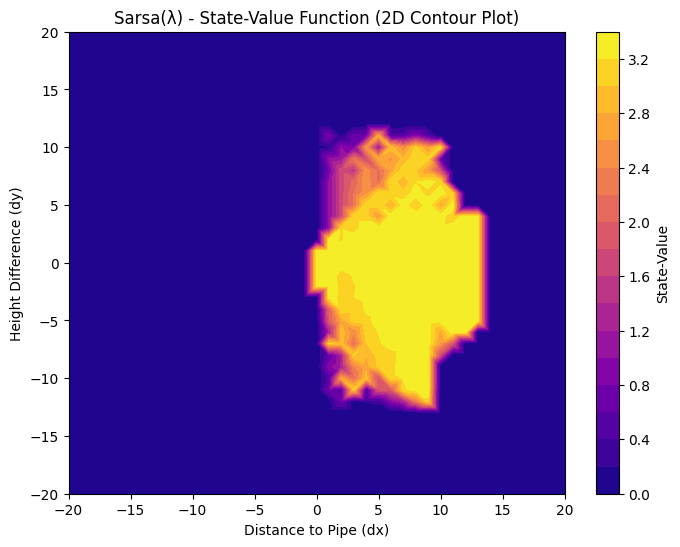

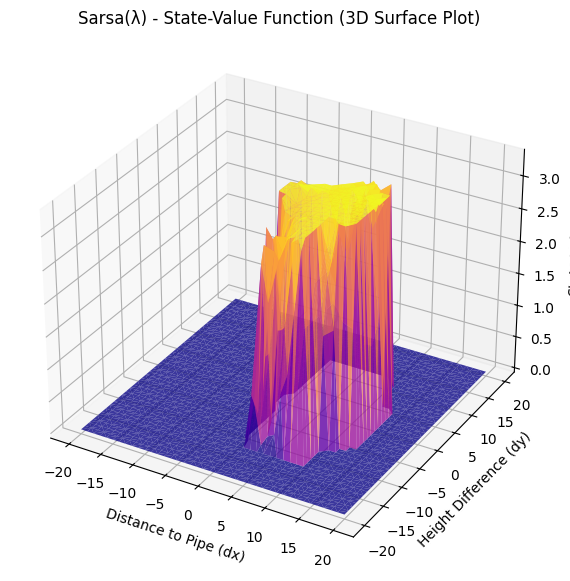

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_value_function_sarsa(Q_sarsa, state_space):

    x_vals = [state[0] for state in state_space]
    y_vals = [state[1] for state in state_space]
    z_vals = [max(Q_sarsa.get(state, [0, 0])) for state in state_space]

    plt.figure(figsize=(8, 6))
    plt.tricontourf(x_vals, y_vals, z_vals, levels=20, cmap="plasma")
    plt.colorbar(label="State-Value")
    plt.title('Sarsa(λ) - State-Value Function (2D Contour Plot)')
    plt.xlabel('Distance to Pipe (dx)')
    plt.ylabel('Height Difference (dy)')
    plt.show()

def plot_value_function_3d_sarsa(Q_sarsa, state_space):

    x_vals = [state[0] for state in state_space]
    y_vals = [state[1] for state in state_space]
    z_vals = [max(Q_sarsa.get(state, [0, 0])) for state in state_space]

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_trisurf(x_vals, y_vals, z_vals, cmap="plasma", alpha=0.8)

    ax.set_title('Sarsa(λ) - State-Value Function (3D Surface Plot)')
    ax.set_xlabel('Distance to Pipe (dx)')
    ax.set_ylabel('Height Difference (dy)')
    ax.set_zlabel('State-Value')
    plt.show()

state_space = [(x, y) for x in range(-20, 21) for y in range(-20, 21)]

plot_value_function_sarsa(Q_sarsa, state_space)

plot_value_function_3d_sarsa(Q_sarsa, state_space)


In [47]:
def test_sarsa_agent_fast(n_episodes):

    total_rewards = []

    for episode in range(n_episodes):
        state, _ = env.reset()
        state = preprocess_state(state)
        done = False
        total_reward = 0

        while not done:
            action = np.argmax(Q_sarsa[state])
            state, reward, done, _, _ = env.step(action)
            state = preprocess_state(state)
            total_reward += reward

            if total_reward >= 100000:
                print(f"Episode {episode + 1} reached a score of {total_reward}, stopping early.")
                break

        total_rewards.append(total_reward)
    print(f"Total rewards over {n_episodes} episodes: {total_rewards}")
    env.close()



test_sarsa_agent_fast(n_episodes=10)

Episode 2 reached a score of 100000, stopping early.
Episode 3 reached a score of 100000, stopping early.
Episode 6 reached a score of 100000, stopping early.
Episode 10 reached a score of 100000, stopping early.
Total rewards over 10 episodes: [68, 100000, 100000, 18, 368, 100000, 1238, 1898, 498, 100000]


In [44]:
def test_sarsa_agent(n_episodes=1):

    for episode in range(n_episodes):
        state, _ = env.reset()
        state = preprocess_state(state)
        done = False
        total_reward = 0

        while not done:

            action = np.argmax(Q_sarsa[state])
            state, reward, done, _, _ = env.step(action)
            state = preprocess_state(state)


            os.system("clear")
            sys.stdout.write(env.render())
            time.sleep(0.01)  # FPS

            total_reward += reward

        print(f"Test Episode {episode + 1}: Total Reward = {total_reward}")

    env.close()

test_sarsa_agent()


Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                    ]
[                    ]
[      @             ]
[                    ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=12,dy=0)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                    ]
[      @             ]
[                    ]
[                    ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=11,dy=-1)
Text Flappy Bird!
Score: 0
----------------------
[      

KeyboardInterrupt: 

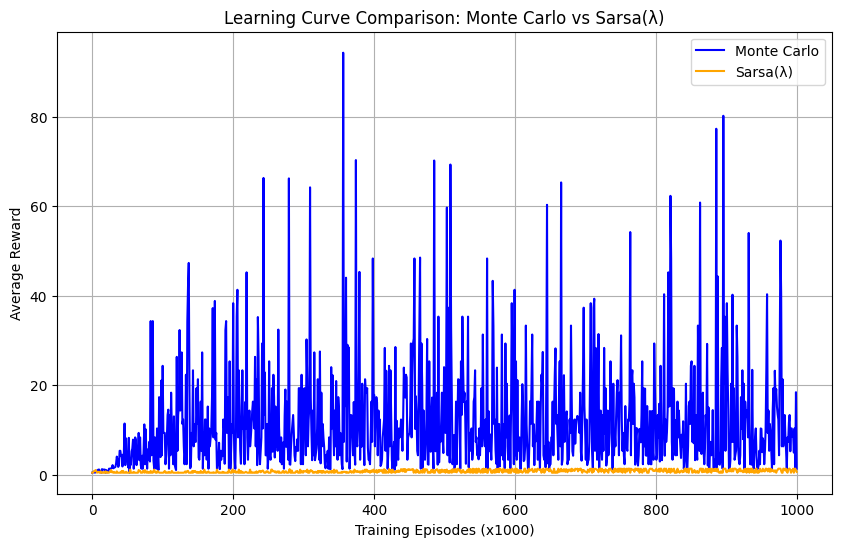

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curve(mc_rewards, sarsa_rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(mc_rewards, label="Monte Carlo", color='blue')
    plt.plot(sarsa_rewards, label="Sarsa(λ)", color='orange')
    plt.xlabel("Training Episodes (x1000)")
    plt.ylabel("Average Reward")
    plt.title("Learning Curve Comparison: Monte Carlo vs Sarsa(λ)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_curve(mc_rewards, sarsa_rewards)


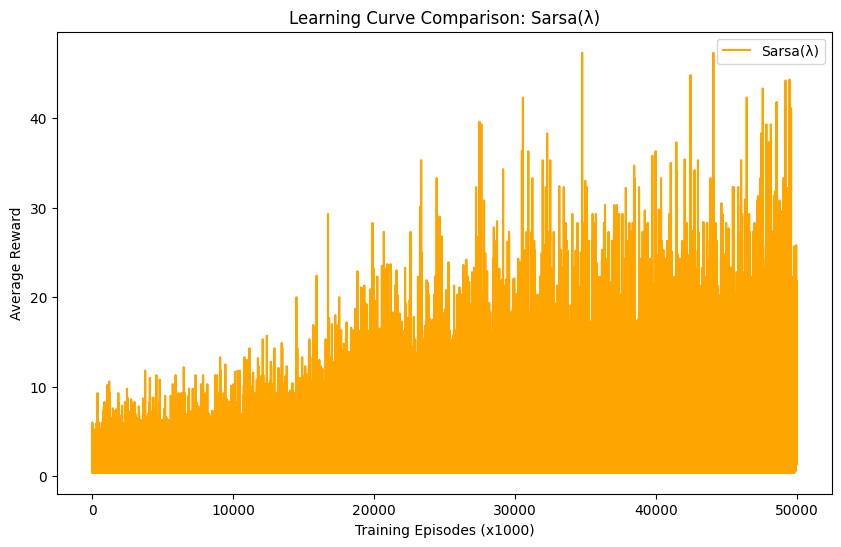

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(sarsa_rewards, label="Sarsa(λ)", color='orange')
plt.xlabel("Training Episodes (x1000)")
plt.ylabel("Average Reward")
plt.title("Learning Curve Comparison: Sarsa(λ)")
plt.legend()
plt.show()